In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import glob
import random
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import BatchNormalization

In [2]:
CATEGORIES=[]
path = 'PokemonData/'
allFileList = os.listdir(path)
for file in allFileList:
    if os.path.isdir(os.path.join(path,file)):
        CATEGORIES.append(file)

150


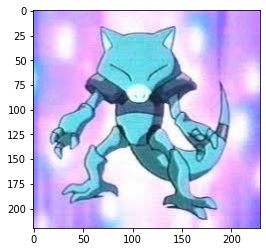

In [3]:
DATADIR='PokemonData/'
num_category=len(CATEGORIES)
print(num_category)
IMG_SIZE=64
#show image
for category in CATEGORIES:    
    path=os.path.join(DATADIR,category)    
    for img in os.listdir(path):        
        img_array=cv2.imread(os.path.join(path,img))        
        plt.imshow(img_array)        
        plt.show        
        break    
    break

In [4]:
whole_data=[]

#input data
def create_whole_data():    
    for category in CATEGORIES:        
        size=0        
        path=os.path.join(DATADIR,category)        
        class_num=CATEGORIES.index(category)        
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))            
                rotate(img_array)
                flip(img_array)            
                color(img_array)            
                zoom(img_array)            
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                whole_data.append([new_array,class_num])
            except:
                continue
                print(img)
        if size<1001:            
            n=1000-size            
            for i in range(n):                
                whole_data.append(expansion(whole_data))
def expansion(whole_data):    
    return random.choice(whole_data)
def flip(x):    
    x = tf.image.random_flip_left_right(x)     
    return x
def rotate(x):    
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))    
    return x
def color(x):    
    x = tf.image.random_hue(x, 0.08)     
    x = tf.image.random_saturation(x, 0.6, 1.6)      
    x = tf.image.random_brightness(x, 0.05)      
    x = tf.image.random_contrast(x, 0.7, 1.3)     
    return x
def zoom(x, scale_min=0.6, scale_max=1.4):    
    h, w, c = x.shape    
    scale = tf.random.uniform([], scale_min, scale_max)      
    sh = h * scale      
    sw = w * scale     
    x = tf.image.resize(x, (sh, sw))      
    x = tf.image.resize_with_crop_or_pad(x, h, w)    
    return x            
create_whole_data()

In [5]:
random.shuffle(whole_data)
for sample in whole_data[:5]:    
    print(sample[1])

0
124
0
1
98


In [6]:
from sklearn.model_selection import train_test_split
train_data, validation_data = train_test_split(whole_data, random_state=777, train_size=0.8)
print(len(train_data))
print(len(validation_data))

125460
31365


In [7]:
#x= pic , y=label
x_train=[]
y_train=[]
for pic,label in train_data:
    x_train.append(pic)
    y_train.append(label)

x_validation=[]
y_validation=[]
for pic,label in validation_data:
    x_validation.append(pic)
    y_validation.append(label)
print(len(x_validation))

31365


In [8]:
train_df = pd.DataFrame(
 {'img': x_train,
 'label': y_train,
 })
train_df.head()

,img,label
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
1,"[[[245, 243, 208], [245, 243, 208], [245, 243,...",0
2,"[[[7, 53, 135], [0, 2, 66], [4, 42, 126], [2, ...",0
3,"[[[210, 218, 221], [212, 220, 223], [208, 216,...",0
4,"[[[79, 111, 226], [32, 67, 96], [48, 50, 152],...",75


In [9]:
validation_df = pd.DataFrame(
 {'img': x_validation,
 'label': y_validation,
 })
validation_df.head()

,img,label
0,"[[[2, 2, 2], [2, 2, 2], [2, 2, 2], [0, 3, 0], ...",0
1,"[[[205, 174, 105], [210, 178, 114], [196, 161,...",0
2,"[[[91, 28, 60], [83, 25, 49], [76, 22, 39], [7...",0
3,"[[[205, 174, 105], [210, 178, 114], [196, 161,...",0
4,"[[[91, 28, 60], [83, 25, 49], [76, 22, 39], [7...",0


In [10]:
x_train_np=np.asarray(x_train)
y_train_np=np.asarray(y_train)
x_validation_np=np.asarray(x_validation)
y_validation_np=np.asarray(y_validation)
print(x_train_np.shape)
print(y_train_np.shape)
print(x_validation_np.shape)
print(y_validation_np.shape)

(125460, 64, 64, 3)
(125460,)
(31365, 64, 64, 3)
(31365,)


In [11]:
x_train_np=x_train_np.astype('float32')/255.0
x_validation_np=x_validation_np.astype('float32')/255.0
x_train_np.shape

(125460, 64, 64, 3)

In [12]:
y_train_onehot = tf.keras.utils.to_categorical(y_train_np, num_classes=num_category)
y_validation_onehot = tf.keras.utils.to_categorical(y_validation_np,
num_classes=num_category)
print(y_train_onehot.shape)
print(y_validation_onehot.shape)

(125460, 150)
(31365, 150)


In [13]:
vgg_model = VGG16(weights='imagenet', include_top=False,
                  input_shape=(IMG_SIZE, IMG_SIZE, 3))

x = Flatten()(vgg_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
outputs = Dense(num_category, activation='softmax')(x)

model = Model(inputs=vgg_model.inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [14]:
#存取最佳權重，並使用EarlyStopping來避免overfitting
vgg_model.trainable = True

trainable_layer = 3
for layer in vgg_model.layers[:-trainable_layer]:
    layer.trainable = False

for layer in model.layers:
    print(layer, layer.trainable)

learning_rate = 1e-4
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

<keras.engine.input_layer.InputLayer object at 0x00000120C8DBF160> False
<keras.layers.convolutional.Conv2D object at 0x00000120D6D8F070> False
<keras.layers.convolutional.Conv2D object at 0x00000120D6D8F760> False
<keras.layers.pooling.MaxPooling2D object at 0x00000120D6D8F6D0> False
<keras.layers.convolutional.Conv2D object at 0x00000120D6E2F4F0> False
<keras.layers.convolutional.Conv2D object at 0x00000120D6E37B80> False
<keras.layers.pooling.MaxPooling2D object at 0x00000120D6E377C0> False
<keras.layers.convolutional.Conv2D object at 0x00000120D6E3D250> False
<keras.layers.convolutional.Conv2D object at 0x00000120D6E42EB0> False
<keras.layers.convolutional.Conv2D object at 0x00000120D6E07E50> False
<keras.layers.pooling.MaxPooling2D object at 0x00000120D6E42AF0> False
<keras.layers.convolutional.Conv2D object at 0x00000120D6E532B0> False
<keras.layers.convolutional.Conv2D object at 0x00000120D6E533A0> False
<keras.layers.convolutional.Conv2D object at 0x00000120D6E4A940> False
<ker

In [15]:
# model_dir = 'model-logs/mid/vgg16'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

logfiles = '/{}-{}'.format('basic_model',
                                       model.__class__.__name__)
model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                        histogram_freq=1)

modelfiles = '/{}-best-model.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,
                                          verbose=1)

callbacks_list = [model_cbk, model_mckp, earlystop]

In [16]:
history = model.fit(x_train_np, y_train_onehot,
                    batch_size=256,
                    epochs=20,
                    validation_data=(x_validation_np, y_validation_onehot),
                    callbacks=callbacks_list)

Epoch 1/20
491/491 [==============================] - 2479s 5s/step - loss: 0.3654 - accuracy: 0.9408 - val_loss: 0.1036 - val_accuracy: 0.9791
Epoch 2/20
491/491 [==============================] - 2479s 5s/step - loss: 0.0429 - accuracy: 0.9922 - val_loss: 0.0600 - val_accuracy: 0.9872
Epoch 3/20
491/491 [==============================] - 2669s 5s/step - loss: 0.0091 - accuracy: 0.9990 - val_loss: 0.0477 - val_accuracy: 0.9895
Epoch 4/20
491/491 [==============================] - 2826s 6s/step - loss: 0.0042 - accuracy: 0.9996 - val_loss: 0.0430 - val_accuracy: 0.9899
Epoch 5/20
491/491 [==============================] - 2431s 5s/step - loss: 0.0030 - accuracy: 0.9997 - val_loss: 0.0418 - val_accuracy: 0.9901
Epoch 6/20
491/491 [==============================] - 2371s 5s/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 0.0468 - val_accuracy: 0.9891
Epoch 7/20
491/491 [==============================] - 2386s 5s/step - loss: 0.0039 - accuracy: 0.9995 - val_loss: 0.0484 - val_accuracy:

In [17]:
model.load_weights(filepath=modelfiles)
score=model.evaluate(x_validation_np,y_validation_onehot,verbose=1)
print("\n Accuracy:{}".format(score[1]))

981/981 [==============================] - 406s 414ms/step - loss: 0.0418 - accuracy: 0.9901

 Accuracy:0.9901163578033447
